# Brain Tumor Segmentation




## Phase 1: Environment Setup

### 1. Create Virtual Environment and Installing Dependencies

**Windows:**   
py -3.12 -m venv venv   
.\venv\Scripts\activate   
pip install -r requirements_windows.txt   

**Max/Linux:**   
python3 -3.12 -m venv venv   
source venv/bin/activate   
pip install -r requirements.txt   

### 2. Import Required Libraries

In [26]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Segmentation Models PyTorch
import segmentation_models_pytorch as smp

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Progress bar
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"Segmentation Models PyTorch: {smp.__version__}")

# HARDWARE CHECK
if torch.cuda.is_available():
    print(f"✓ Hardware: NVIDIA GPU ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    print(f"✓ Hardware: Apple Silicon (M-Series)")
else:
    print(f"⚠ Hardware: CPU Only")

PyTorch Version: 2.8.0
Segmentation Models PyTorch: 0.5.0
✓ Hardware: Apple Silicon (M-Series)


### 3. Configuration and Paths

In [27]:
# PATHS
DATASET_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALID_DIR = os.path.join(DATASET_DIR, 'valid')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

TRAIN_ANNOTATIONS = os.path.join(TRAIN_DIR, '_annotations.coco.json')
VALID_ANNOTATIONS = os.path.join(VALID_DIR, '_annotations.coco.json')
TEST_ANNOTATIONS = os.path.join(TEST_DIR, '_annotations.coco.json')

MODEL_SAVE_DIR = 'models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

RESULTS_DIR = 'results'
MASK_OUTPUT_DIR = os.path.join(RESULTS_DIR, 'masks')
OVERLAY_OUTPUT_DIR = os.path.join(RESULTS_DIR, 'overlays')
OUTPUT_JSON_PATH = os.path.join(RESULTS_DIR, '_annotations.coco.json')

# TRAINING SETTINGS
USE_CHECKPOINT = False
BATCH_SIZE = 4
NUM_EPOCHS = 50
NUM_WORKERS = 0
EARLY_STOP_PATIENCE = 20
MAX_GRAD_NORM = 1.0

# UNIVERSAL DEVICE CONFIGURATION
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    DEVICE_TYPE = 'cuda'
    USE_AMP = True   # Enable Mixed Precision for NVIDIA
    print("• Configuration: CUDA (NVIDIA) - AMP Enabled")
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    DEVICE_TYPE = 'mps'
    USE_AMP = False  # Disable AMP for Mac (Standard Precision is more stable)
    print("• Configuration: MPS (Apple Silicon) - AMP Disabled")
else:
    DEVICE = torch.device('cpu')
    DEVICE_TYPE = 'cpu'
    USE_AMP = False
    print("• Configuration: CPU - AMP Disabled")

# IMAGE SETTINGS
ORIGINAL_IMG_SIZE = (640, 640)
IMG_SIZE = (384, 384)       # Training resolution

# SEGMENTATION SETTINGS
# Class 0: Background, 1: Tumor type 0, 2: Tumor type 1
NUM_CLASSES = 3
TUMOR_CATEGORY_IDS = [1, 2]

# Visualization colors (RGB)
CLASS_COLORS = {
    0: (0, 0, 0),           # Background - Black
    1: (255, 0, 0),         # Tumor type 0 - Red
    2: (0, 0, 255),         # Tumor type 1 - Blue
}

# Post-processing
MIN_CONTOUR_AREA = 50       # Minimum contour area to filter noise

# INFERENCE SETTINGS
USE_TTA = False

# Print configuration summary
print(f"Resolution:  {IMG_SIZE}")
print(f"Batch size:  {BATCH_SIZE}")
print(f"Epochs:      {NUM_EPOCHS}")

• Configuration: MPS (Apple Silicon) - AMP Disabled
Resolution:  (384, 384)
Batch size:  4
Epochs:      50


## Phase 2: Data Understanding and Preprocessing

### 4. Explore COCO JSON Structure

**Multi-Class Segmentation Strategy:**

The COCO dataset has 3 categories:
- Category 0: "Tumor" (parent category, not used in annotations)
- Category 1: "0" (tumor subtype, ~771 annotations) → **Class 1 (Red)**
- Category 2: "1" (tumor subtype, ~731 annotations) → **Class 2 (Blue)**

**Approach:** We train a **multi-class segmentation** model with 3 output classes:
- **Class 0**: Background (no tumor)
- **Class 1**: Tumor type "0" (COCO category_id=1)
- **Class 2**: Tumor type "1" (COCO category_id=2)

This allows the model to learn discriminative features for each tumor type. Final output masks will be binary (tumor vs background) but the COCO JSON will include the predicted tumor category.

In [28]:
# Load and explore COCO annotations
with open(TRAIN_ANNOTATIONS, 'r') as f:
    coco_data = json.load(f)

print("COCO JSON Keys:", coco_data.keys())
print("\n=== Categories ===")
for cat in coco_data['categories']:
    print(f"  ID: {cat['id']}, Name: '{cat['name']}', Supercategory: '{cat['supercategory']}'")

print(f"\n=== Dataset Statistics ===")
print(f"Total images: {len(coco_data['images'])}")
print(f"Total annotations: {len(coco_data['annotations'])}")

# Count annotations by category
category_counts = Counter([ann['category_id'] for ann in coco_data['annotations']])
print("\nAnnotations per category:")
for cat_id, count in sorted(category_counts.items()):
    cat_name = next(c['name'] for c in coco_data['categories'] if c['id'] == cat_id)
    print(f"  Category {cat_id} ('{cat_name}'): {count}")

print(f"\n=== Segmentation Strategy ===")
print(f"Categories {TUMOR_CATEGORY_IDS} mapped to classes 1 and 2")
total_tumor_anns = sum(count for cat_id, count in category_counts.items() if cat_id in TUMOR_CATEGORY_IDS)
print(f"Total tumor annotations: {total_tumor_anns}")

# Analyze images with tumor
images_with_tumor = len(set([ann['image_id'] for ann in coco_data['annotations'] 
                              if ann['category_id'] in TUMOR_CATEGORY_IDS]))
print(f"Images with tumor: {images_with_tumor}/{len(coco_data['images'])} ({images_with_tumor/len(coco_data['images'])*100:.1f}%)")

# Show sample annotation
print("\n=== Sample Annotation ===")
sample_ann = coco_data['annotations'][0]
for key, value in sample_ann.items():
    if key == 'segmentation':
        print(f"  {key}: [polygon with {len(value[0])} coordinates]")
    else:
        print(f"  {key}: {value}")

COCO JSON Keys: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

=== Categories ===
  ID: 0, Name: 'Tumor', Supercategory: 'none'
  ID: 1, Name: '0', Supercategory: 'Tumor'
  ID: 2, Name: '1', Supercategory: 'Tumor'

=== Dataset Statistics ===
Total images: 1502
Total annotations: 1502

Annotations per category:
  Category 1 ('0'): 771
  Category 2 ('1'): 731

=== Segmentation Strategy ===
Categories [1, 2] mapped to classes 1 and 2
Total tumor annotations: 1502
Images with tumor: 1501/1502 (99.9%)

=== Sample Annotation ===
  id: 0
  image_id: 0
  category_id: 1
  bbox: [145, 239, 168.75, 162.5]
  area: 27421.875
  segmentation: [polygon with 10 coordinates]
  iscrowd: 0


### 5. Custom Dataset Class (COCO JSON → Multi-Class Masks)

In [29]:
class BrainTumorDataset(Dataset):
    """
    Custom Dataset for Brain Tumor Segmentation.
    Converts COCO polygon annotations to multi-class masks.
    
    Mask values:
    - 0: Background
    - 1: Tumor type "0" (COCO category_id=1)
    - 2: Tumor type "1" (COCO category_id=2)
    """
    
    def __init__(self, img_dir, annotation_file, transform=None, is_test=False):
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create image ID to filename mapping
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.image_ids = list(self.images.keys())
        
        if not is_test:
            # Group annotations by image_id
            self.annotations = {}
            for ann in self.coco_data['annotations']:
                img_id = ann['image_id']
                if img_id not in self.annotations:
                    self.annotations[img_id] = []
                self.annotations[img_id].append(ann)
    
    def __len__(self):
        return len(self.image_ids)
    
    def _polygon_to_mask(self, polygons, img_height, img_width):
        """
        Convert COCO polygons to multi-class mask.
        
        Returns mask with values:
        - 0: Background
        - 1: Tumor type "0" (COCO category_id=1)
        - 2: Tumor type "1" (COCO category_id=2)
        """
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        for ann in polygons:
            category_id = ann['category_id']
            
            # Skip if not a tumor category
            if category_id not in TUMOR_CATEGORY_IDS:
                continue
            
            # Map COCO category_id to class index (1 or 2)
            class_value = category_id  # category_id 1 -> class 1, category_id 2 -> class 2
            
            # Get segmentation polygons
            segmentation = ann['segmentation']
            
            for seg in segmentation:
                # Convert [x1, y1, x2, y2, ...] to [[x1, y1], [x2, y2], ...]
                points = np.array(seg).reshape(-1, 2).astype(np.int32)
                
                # Draw filled polygon with class value
                cv2.fillPoly(mask, [points], color=int(class_value))
        
        return mask
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_filename = img_info['file_name']
        img_path = os.path.join(self.img_dir, img_filename)
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.is_test:
            # Test set: no masks
            if self.transform:
                transformed = self.transform(image=image)
                image = transformed['image']
            return image, img_id, img_filename
        
        # Get annotations
        img_annotations = self.annotations.get(img_id, [])
        
        # Convert polygons to multi-class mask
        height, width = image.shape[:2]
        mask = self._polygon_to_mask(img_annotations, height, width)
        
        # Apply augmentations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            # Keep mask as long tensor for CrossEntropyLoss (no channel dim needed)
            if isinstance(mask, torch.Tensor):
                mask = mask.long()
            else:
                mask = torch.from_numpy(mask).long()
        else:
            # No transform applied, convert manually
            mask = torch.from_numpy(mask).long()
        
        return image, mask

print("✓ BrainTumorDataset class defined (Multi-class)")
print(f"  Class 0: Background")
print(f"  Class 1: Tumor type '0' (COCO category_id=1)")
print(f"  Class 2: Tumor type '1' (COCO category_id=2)")

✓ BrainTumorDataset class defined (Multi-class)
  Class 0: Background
  Class 1: Tumor type '0' (COCO category_id=1)
  Class 2: Tumor type '1' (COCO category_id=2)


### 6. Data Augmentation with Albumentations

In [8]:
def get_train_transform():
    """Simplified augmentation for training - focus on geometric transforms"""
    return A.Compose([
        A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1]),
        # Basic geometric augmentations (most helpful for medical imaging)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # Mild shift/scale/rotate
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, 
                           border_mode=cv2.BORDER_REFLECT, p=0.5),
        # Light brightness/contrast adjustment
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
        # Normalize
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_valid_transform():
    """Augmentation for validation/test"""
    return A.Compose([
        A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

print("✓ Simplified augmentation pipelines defined")
print("  Removed: ElasticTransform, GridDistortion, CLAHE, Gamma, Noise/Blur")
print("  Kept: Flips, Rotate90, mild ShiftScaleRotate, light BrightnessContrast")

✓ Simplified augmentation pipelines defined
  Removed: ElasticTransform, GridDistortion, CLAHE, Gamma, Noise/Blur
  Kept: Flips, Rotate90, mild ShiftScaleRotate, light BrightnessContrast


### 7. Visualize Sample Images and Masks

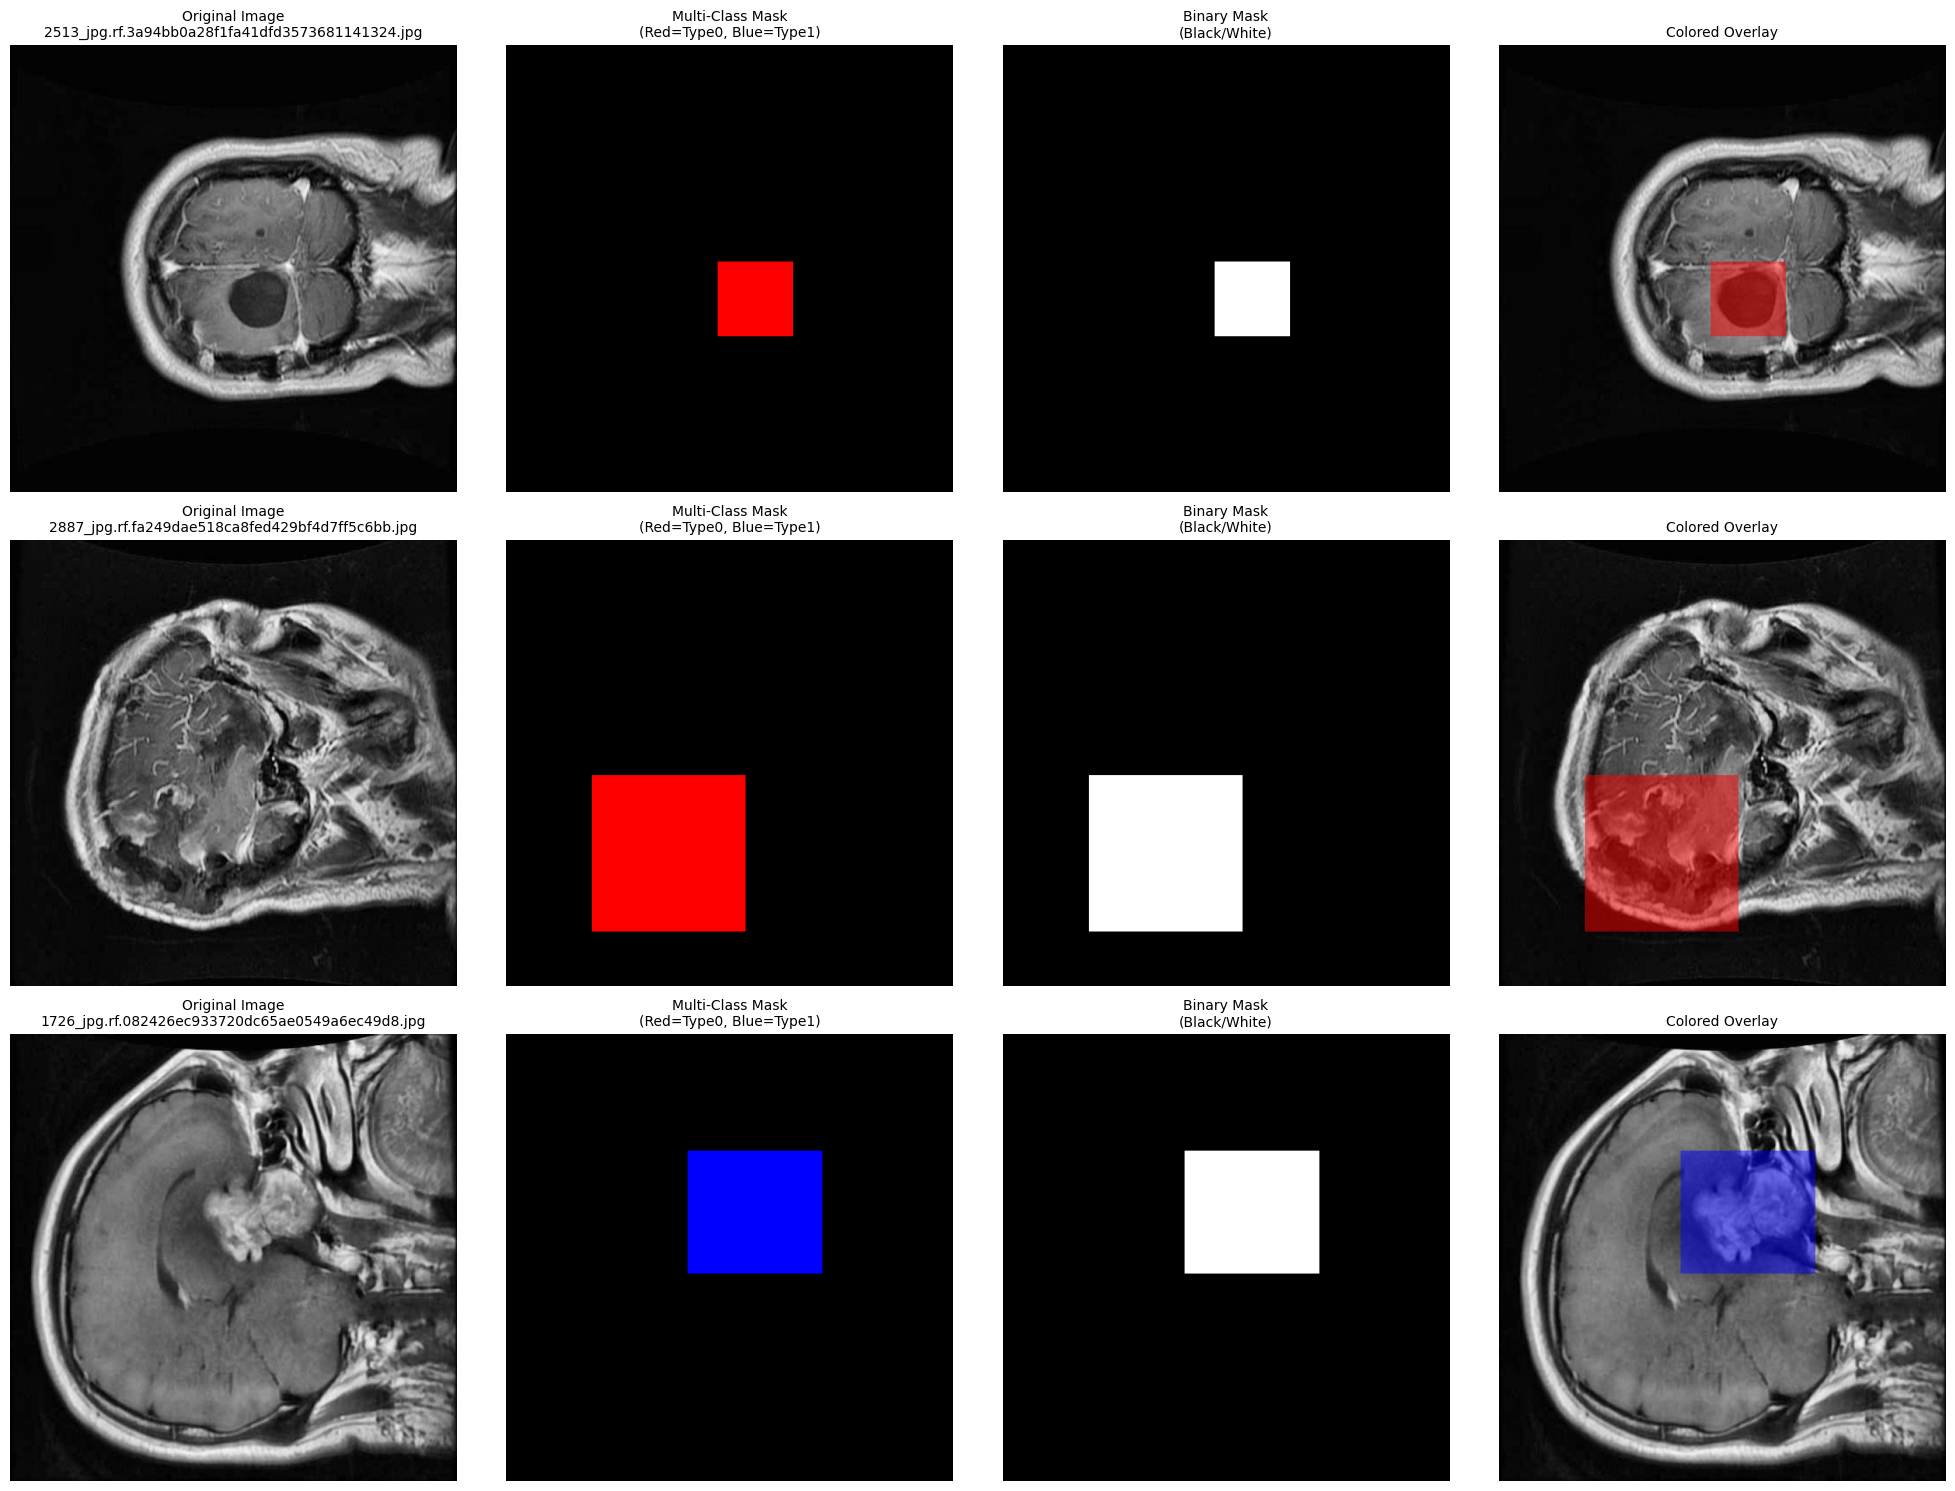


✓ Visualized 3 sample images with multi-class tumor masks
  Legend: ⬛ Black = Background, 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1


In [9]:
# Simple dataset for visualization (without augmentations)
class SimpleDataset(Dataset):
    """Dataset for visualization without augmentations."""
    
    def __init__(self, img_dir, annotation_file):
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        self.img_dir = img_dir
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.image_ids = list(self.images.keys())
        
        # Group annotations by image_id
        self.annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create multi-class mask
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        for ann in self.annotations.get(img_id, []):
            category_id = ann['category_id']
            if category_id in TUMOR_CATEGORY_IDS:
                for seg in ann['segmentation']:
                    points = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [points], color=int(category_id))
        
        return image, mask, img_info['file_name']


def mask_to_color(mask):
    """Convert multi-class mask to RGB color image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask


# Visualize samples
viz_dataset = SimpleDataset(TRAIN_DIR, TRAIN_ANNOTATIONS)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i in range(3):
    idx = np.random.randint(0, len(viz_dataset))
    image, mask, filename = viz_dataset[idx]
    
    # Create colored mask
    color_mask = mask_to_color(mask)
    
    # Create binary mask
    binary_mask = (mask > 0).astype(np.uint8)
    
    # Create overlay
    overlay = image.copy().astype(np.float32)
    for class_id in [1, 2]:
        class_mask = (mask == class_id)
        if class_mask.any():
            color = np.array(CLASS_COLORS[class_id])
            overlay[class_mask] = overlay[class_mask] * 0.5 + color * 0.5
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image\n{filename}", fontsize=10)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(color_mask)
    axes[i, 1].set_title("Multi-Class Mask\n(Red=Type0, Blue=Type1)", fontsize=10)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(binary_mask, cmap='gray')
    axes[i, 2].set_title("Binary Mask\n(Black/White)", fontsize=10)
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(overlay.astype(np.uint8))
    axes[i, 3].set_title("Colored Overlay", fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visualized 3 sample images with multi-class tumor masks")
print("  Legend: ⬛ Black = Background, 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1")

## Phase 3: Model Design and Training

### 8. U-Net Architecture Implementation

U-Net consists of:
- **Encoder**: Downsampling path (4 blocks)
- **Bottleneck**: Lowest resolution processing
- **Decoder**: Upsampling path with skip connections (4 blocks)
- **Output**: 3 channels for multi-class segmentation (background + 2 tumor types)

In [10]:
# EfficientNet-B4 UNet++ model for multi-class segmentation
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,  # 3 classes: background, tumor type 0, tumor type 1
    activation=None,
)
model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"✓ EfficientNet-B4 UNet++ model created (Multi-class)")
print(f"  Output classes: {NUM_CLASSES}")
print(f"  Total parameters: {total_params:,}")

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

✓ EfficientNet-B4 UNet++ model created (Multi-class)
  Output classes: 3
  Total parameters: 20,813,403


### 9. Loss Functions and Metrics

In [11]:
# LOSS FUNCTIONS
class MultiClassDiceLoss(nn.Module):
    """Dice Loss for multi-class segmentation."""
    
    def __init__(self, num_classes=3, smooth=1e-5, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_weights = class_weights or [1.0] * num_classes
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W) logits
            targets: (B, H, W) class indices
        """
        probs = F.softmax(predictions, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float().contiguous()
        
        total_loss = 0.0
        total_weight = sum(self.class_weights)
        
        for c in range(self.num_classes):
            pred_c = probs[:, c].reshape(-1)
            target_c = targets_one_hot[:, c].reshape(-1)
            
            intersection = (pred_c * target_c).sum()
            dice = (2. * intersection + self.smooth) / (pred_c.sum() + target_c.sum() + self.smooth)
            total_loss += self.class_weights[c] * (1 - dice)
        
        return total_loss / total_weight


class MultiClassFocalLoss(nn.Module):
    """Focal Loss for multi-class segmentation with class imbalance."""
    
    def __init__(self, alpha=None, gamma=2.0, num_classes=3):
        super().__init__()
        self.gamma = gamma
        self.num_classes = num_classes
        self.alpha = alpha if alpha is not None else torch.tensor([0.2, 0.4, 0.4])
    
    def forward(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        alpha = self.alpha.to(predictions.device)
        alpha_t = alpha[targets]
        
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# METRICS
def calculate_iou_multiclass(predictions, targets, num_classes=3, exclude_background=True):
    """
    Calculate mean IoU for multi-class segmentation.
    
    Args:
        predictions: (B, C, H, W) logits or (B, H, W) class indices
        targets: (B, H, W) class indices
        num_classes: Number of classes
        exclude_background: Whether to exclude class 0 from calculation
    
    Returns:
        mean_iou: Mean IoU across classes
        class_ious: Dictionary of per-class IoU values
    """
    if predictions.dim() == 4:
        pred_classes = predictions.argmax(dim=1)
    else:
        pred_classes = predictions
    
    ious = []
    class_ious = {}
    start_class = 1 if exclude_background else 0
    
    for c in range(start_class, num_classes):
        pred_c = (pred_classes == c)
        target_c = (targets == c)
        
        intersection = (pred_c & target_c).float().sum()
        union = (pred_c | target_c).float().sum()
        
        if union > 0:
            iou = intersection / union
            ious.append(iou.item())
            class_ious[c] = iou.item()
        else:
            class_ious[c] = None
    
    mean_iou = np.mean(ious) if ious else 0.0
    return mean_iou, class_ious


def calculate_dice_multiclass(predictions, targets, num_classes=3, exclude_background=True):
    """Calculate mean Dice score for multi-class segmentation."""
    if predictions.dim() == 4:
        pred_classes = predictions.argmax(dim=1)
    else:
        pred_classes = predictions
    
    dices = []
    start_class = 1 if exclude_background else 0
    
    for c in range(start_class, num_classes):
        pred_c = (pred_classes == c).float()
        target_c = (targets == c).float()
        
        intersection = (pred_c * target_c).sum()
        denominator = pred_c.sum() + target_c.sum()
        
        if denominator > 0:
            dice = (2. * intersection) / denominator
            dices.append(dice.item())
    
    return np.mean(dices) if dices else 0.0


def calculate_binary_iou(predictions, targets):
    """
    Calculate binary IoU (tumor vs background) from multi-class predictions.
    Only computes IoU on images that contain actual tumors.
    """
    if predictions.dim() == 4:
        pred_classes = predictions.argmax(dim=1)
    else:
        pred_classes = predictions
    
    # Binary: any tumor (class 1 or 2) vs background (class 0)
    pred_tumor = (pred_classes > 0)
    target_tumor = (targets > 0)
    
    # Only compute on images with actual tumors
    has_tumor = target_tumor.sum(dim=(1, 2)) > 0
    
    if has_tumor.sum() == 0:
        return 0.0
    
    intersection = (pred_tumor & target_tumor).float().sum(dim=(1, 2))
    union = (pred_tumor | target_tumor).float().sum(dim=(1, 2))
    
    iou = torch.where(union > 0, intersection / union, torch.zeros_like(union))
    
    return (iou * has_tumor.float()).sum().item() / has_tumor.sum().item()


# TEST-TIME AUGMENTATION (TTA)
def apply_tta_augmentations(image_tensor):
    """
    Generate augmented versions of input with their reverse transforms.
    
    Args:
        image_tensor: (B, C, H, W) input tensor
    
    Returns:
        List of (augmented_tensor, reverse_function) tuples
    """
    return [
        (image_tensor, lambda x: x),                                              # Original
        (torch.flip(image_tensor, dims=[3]), lambda x: torch.flip(x, dims=[3])),  # H-flip
        (torch.flip(image_tensor, dims=[2]), lambda x: torch.flip(x, dims=[2])),  # V-flip
        (torch.flip(image_tensor, dims=[2, 3]), lambda x: torch.flip(x, dims=[2, 3])),  # Both
        (torch.rot90(image_tensor, k=1, dims=[2, 3]), 
         lambda x: torch.rot90(x, k=-1, dims=[2, 3])),  # 90°
        (torch.rot90(image_tensor, k=2, dims=[2, 3]), 
         lambda x: torch.rot90(x, k=2, dims=[2, 3])),   # 180°
        (torch.rot90(image_tensor, k=3, dims=[2, 3]), 
         lambda x: torch.rot90(x, k=1, dims=[2, 3])),   # 270°
        (torch.flip(torch.rot90(image_tensor, k=1, dims=[2, 3]), dims=[3]),
         lambda x: torch.rot90(torch.flip(x, dims=[3]), k=-1, dims=[2, 3])),  # 90° + H-flip
    ]


def predict_with_tta(model, image_tensor, device):
    """
    Run inference with Test-Time Augmentation.
    
    Args:
        model: Trained model
        image_tensor: (B, C, H, W) input tensor
        device: torch device
    
    Returns:
        Averaged probability tensor (B, C, H, W)
    """
    augmented_inputs = apply_tta_augmentations(image_tensor)
    accumulated_probs = None
    
    with torch.no_grad():
        for aug_tensor, reverse_fn in augmented_inputs:
            output = model(aug_tensor.to(device))
            probs = torch.softmax(output, dim=1)
            reversed_probs = reverse_fn(probs)
            
            if accumulated_probs is None:
                accumulated_probs = reversed_probs
            else:
                accumulated_probs = accumulated_probs + reversed_probs
    
    return accumulated_probs / len(augmented_inputs)


print("✓ Loss functions defined:")
print("  - MultiClassDiceLoss")
print("  - MultiClassFocalLoss")
print("\n✓ Metrics defined:")
print("  - calculate_iou_multiclass")
print("  - calculate_dice_multiclass")
print("  - calculate_binary_iou")
print("\n✓ TTA functions defined:")
print("  - apply_tta_augmentations (8 augmentations)")
print("  - predict_with_tta")

✓ Loss functions defined:
  - MultiClassDiceLoss
  - MultiClassFocalLoss

✓ Metrics defined:
  - calculate_iou_multiclass
  - calculate_dice_multiclass
  - calculate_binary_iou

✓ TTA functions defined:
  - apply_tta_augmentations (8 augmentations)
  - predict_with_tta


### 10. Create DataLoaders

In [12]:
# Create datasets
train_dataset = BrainTumorDataset(
    img_dir=TRAIN_DIR,
    annotation_file=TRAIN_ANNOTATIONS,
    transform=get_train_transform(),
    is_test=False
)

valid_dataset = BrainTumorDataset(
    img_dir=VALID_DIR,
    annotation_file=VALID_ANNOTATIONS,
    transform=get_valid_transform(),
    is_test=False
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

print(f"✓ Datasets created")
print(f"  Train: {len(train_dataset)} images")
print(f"  Valid: {len(valid_dataset)} images")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")

✓ Datasets created
  Train: 1502 images
  Valid: 429 images
  Train batches: 376
  Valid batches: 108


### 11. Training Loop

In [13]:
# LOSS FUNCTION
class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-5, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, pred, target):
        # pred: [B, C, H, W] (softmax applied or logits)
        # target: [B, H, W] (class indices 0..C-1)
        pred = torch.softmax(pred, dim=1)
        
        dice_loss = 0.0
        for class_index in range(self.num_classes):
            pred_class = pred[:, class_index, :, :]
            target_class = (target == class_index).float()
            
            intersection = (pred_class * target_class).sum(dim=(1, 2))
            union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2))
            
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            class_loss = 1.0 - dice.mean()
            
            if self.class_weights:
                class_loss *= self.class_weights[class_index]
                
            dice_loss += class_loss
            
        return dice_loss / self.num_classes

criterion_dice = MultiClassDiceLoss(
    num_classes=NUM_CLASSES, 
    class_weights=[0.2, 0.4, 0.4]  # Lower weight for background
)

# OPTIMIZER
encoder_params = list(model.encoder.parameters())
decoder_params = list(model.decoder.parameters()) + list(model.segmentation_head.parameters())

optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': 5e-5},   # Pretrained encoder: lower LR
    {'params': decoder_params, 'lr': 2e-4},   # Decoder: higher LR
], weight_decay=2e-4)

# SCHEDULER
total_steps = NUM_EPOCHS * len(train_loader)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[5e-4, 2e-3],
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100
)

# UNIVERSAL SCALER (Uses dummy if not on CUDA/AMP disabled)
if DEVICE_TYPE == 'cuda' and USE_AMP:
    scaler = torch.amp.GradScaler('cuda')
else:
    # Create a dummy scaler for Mac/CPU that does nothing but pass-through
    class DummyScaler:
        def scale(self, loss): return loss
        def step(self, optimizer): optimizer.step()
        def update(self): pass
        def unscale_(self, optimizer): pass
    scaler = DummyScaler()

# TRAINING STATE
history = {
    'train_loss': [], 'train_iou': [], 'train_dice': [], 'train_binary_iou': [],
    'val_loss': [], 'val_iou': [], 'val_dice': [], 'val_binary_iou': []
}
best_val_iou = 0.0
start_epoch = 0
early_stop_counter = 0

print(f"\nTraining: {NUM_EPOCHS} epochs, {NUM_CLASSES} classes")
print(f"Device: {DEVICE_TYPE.upper()} | AMP: {'On' if USE_AMP else 'Off'}\n")

# TRAINING LOOP
for epoch in range(start_epoch, NUM_EPOCHS):
    # ----- Training Phase -----
    model.train()
    train_loss = train_iou = train_dice = train_binary_iou = 0.0
    num_train_batches = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in train_pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Universal Autocast
        with torch.amp.autocast(device_type=DEVICE_TYPE, enabled=USE_AMP):
            outputs = model(images)
            loss = criterion_dice(outputs, masks)
        
        # Backward pass with scaler
        scaler.scale(loss).backward()
        
        if USE_AMP and DEVICE_TYPE == 'cuda':
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            
        scheduler.step()
        
        # Metrics (detach to prevent graph retention)
        with torch.no_grad():
            iou, _ = calculate_iou_multiclass(outputs.detach(), masks, NUM_CLASSES)
            dice = calculate_dice_multiclass(outputs.detach(), masks, NUM_CLASSES)
            binary_iou = calculate_binary_iou(outputs.detach(), masks)
        
        train_loss += loss.item()
        train_iou += iou
        train_dice += dice
        train_binary_iou += binary_iou
        num_train_batches += 1
        
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}', 
            'iou': f'{iou:.4f}', 
            'bin_iou': f'{binary_iou:.4f}'
        })
    
    # Averages
    train_loss /= num_train_batches
    train_iou /= num_train_batches
    train_dice /= num_train_batches
    train_binary_iou /= num_train_batches
    
    # ----- Validation Phase -----
    model.eval()
    val_loss = val_iou = val_dice = val_binary_iou = 0.0
    num_val_batches = 0
    
    with torch.no_grad():
        val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]")
        for images, masks in val_pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            
            with torch.amp.autocast(device_type=DEVICE_TYPE, enabled=USE_AMP):
                outputs = model(images)
                loss = criterion_dice(outputs, masks)
            
            iou, _ = calculate_iou_multiclass(outputs, masks, NUM_CLASSES)
            dice = calculate_dice_multiclass(outputs, masks, NUM_CLASSES)
            binary_iou = calculate_binary_iou(outputs, masks)
            
            val_loss += loss.item()
            val_iou += iou
            val_dice += dice
            val_binary_iou += binary_iou
            num_val_batches += 1
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}', 
                'iou': f'{iou:.4f}', 
                'bin_iou': f'{binary_iou:.4f}'
            })
    
    val_loss /= num_val_batches
    val_iou /= num_val_batches
    val_dice /= num_val_batches
    val_binary_iou /= num_val_batches
    
    # ----- Update History -----
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"\nEpoch {epoch+1}: Train mIoU={train_iou:.4f}, Val mIoU={val_iou:.4f}, Val Binary IoU={val_binary_iou:.4f}")
    
    # ----- Save Best Model -----
    if val_binary_iou > best_val_iou:
        best_val_iou = val_binary_iou
        early_stop_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'binary_iou': val_binary_iou,
        }, BEST_MODEL_PATH)
        print(f"  ✓ Best model saved")
    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠️ Early stopping triggered!")
            break
    
    print("-" * 50)


Training: 50 epochs, 3 classes
Device: MPS | AMP: Off



Epoch 1/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:22<00:00,  4.70it/s, loss=0.1498, iou=0.4104, bin_iou=0.4994]



Epoch 1: Train mIoU=0.2574, Val mIoU=0.4511, Val Binary IoU=0.4707
  ✓ Best model saved
--------------------------------------------------


Epoch 2/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.20it/s, loss=0.1667, iou=0.3041, bin_iou=0.4862]



Epoch 2: Train mIoU=0.4144, Val mIoU=0.4962, Val Binary IoU=0.5059
  ✓ Best model saved
--------------------------------------------------


Epoch 3/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:22<00:00,  4.89it/s, loss=0.1726, iou=0.5489, bin_iou=0.5489]



Epoch 3: Train mIoU=0.4295, Val mIoU=0.4695, Val Binary IoU=0.5208
  ✓ Best model saved
--------------------------------------------------


Epoch 4/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.1921, iou=0.3914, bin_iou=0.3914]



Epoch 4: Train mIoU=0.4384, Val mIoU=0.4323, Val Binary IoU=0.4999
--------------------------------------------------


Epoch 5/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.18it/s, loss=0.1983, iou=0.1730, bin_iou=0.3434]



Epoch 5: Train mIoU=0.4286, Val mIoU=0.4943, Val Binary IoU=0.5500
  ✓ Best model saved
--------------------------------------------------


Epoch 6/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.21it/s, loss=0.1490, iou=0.3977, bin_iou=0.4308]



Epoch 6: Train mIoU=0.4410, Val mIoU=0.4416, Val Binary IoU=0.5420
--------------------------------------------------


Epoch 7/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.23it/s, loss=0.1536, iou=0.3688, bin_iou=0.7303]



Epoch 7: Train mIoU=0.4785, Val mIoU=0.5592, Val Binary IoU=0.6244
  ✓ Best model saved
--------------------------------------------------


Epoch 8/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.29it/s, loss=0.1444, iou=0.4255, bin_iou=0.6240]



Epoch 8: Train mIoU=0.4915, Val mIoU=0.4561, Val Binary IoU=0.4992
--------------------------------------------------


Epoch 9/50 [Valid]: 100%|███████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.1416, iou=0.4447, bin_iou=0.5629]



Epoch 9: Train mIoU=0.5147, Val mIoU=0.5283, Val Binary IoU=0.5723
--------------------------------------------------


Epoch 10/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  4.99it/s, loss=0.1430, iou=0.4339, bin_iou=0.7409]



Epoch 10: Train mIoU=0.4874, Val mIoU=0.5802, Val Binary IoU=0.6306
  ✓ Best model saved
--------------------------------------------------


Epoch 11/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.20it/s, loss=0.1502, iou=0.7723, bin_iou=0.7723]



Epoch 11: Train mIoU=0.4893, Val mIoU=0.4845, Val Binary IoU=0.5654
--------------------------------------------------


Epoch 12/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.15it/s, loss=0.0674, iou=0.3299, bin_iou=0.3299]



Epoch 12: Train mIoU=0.5117, Val mIoU=0.5471, Val Binary IoU=0.5737
--------------------------------------------------


Epoch 13/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.07it/s, loss=0.0168, iou=0.7766, bin_iou=0.7766]



Epoch 13: Train mIoU=0.5158, Val mIoU=0.6079, Val Binary IoU=0.6383
  ✓ Best model saved
--------------------------------------------------


Epoch 14/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.23it/s, loss=0.0221, iou=0.7177, bin_iou=0.7177]



Epoch 14: Train mIoU=0.5347, Val mIoU=0.6229, Val Binary IoU=0.6454
  ✓ Best model saved
--------------------------------------------------


Epoch 15/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.0182, iou=0.7599, bin_iou=0.7599]



Epoch 15: Train mIoU=0.5442, Val mIoU=0.6334, Val Binary IoU=0.6696
  ✓ Best model saved
--------------------------------------------------


Epoch 16/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.12it/s, loss=0.0121, iou=0.8355, bin_iou=0.8355]



Epoch 16: Train mIoU=0.5516, Val mIoU=0.5657, Val Binary IoU=0.6165
--------------------------------------------------


Epoch 17/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.25it/s, loss=0.0148, iou=0.8018, bin_iou=0.8018]



Epoch 17: Train mIoU=0.5542, Val mIoU=0.6663, Val Binary IoU=0.6712
  ✓ Best model saved
--------------------------------------------------


Epoch 18/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.0185, iou=0.7574, bin_iou=0.7574]



Epoch 18: Train mIoU=0.5834, Val mIoU=0.6383, Val Binary IoU=0.6529
--------------------------------------------------


Epoch 19/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.28it/s, loss=0.1533, iou=0.3751, bin_iou=0.2825]



Epoch 19: Train mIoU=0.5660, Val mIoU=0.6200, Val Binary IoU=0.6487
--------------------------------------------------


Epoch 20/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.0137, iou=0.8151, bin_iou=0.8151]



Epoch 20: Train mIoU=0.5719, Val mIoU=0.6381, Val Binary IoU=0.6637
--------------------------------------------------


Epoch 21/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.23it/s, loss=0.0183, iou=0.7599, bin_iou=0.7599]



Epoch 21: Train mIoU=0.5954, Val mIoU=0.6343, Val Binary IoU=0.6639
--------------------------------------------------


Epoch 22/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.0129, iou=0.8248, bin_iou=0.8248]



Epoch 22: Train mIoU=0.6004, Val mIoU=0.6626, Val Binary IoU=0.6692
--------------------------------------------------


Epoch 23/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.32it/s, loss=0.0147, iou=0.8019, bin_iou=0.8019]



Epoch 23: Train mIoU=0.6065, Val mIoU=0.6666, Val Binary IoU=0.6772
  ✓ Best model saved
--------------------------------------------------


Epoch 24/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.01it/s, loss=0.0165, iou=0.7815, bin_iou=0.7815]



Epoch 24: Train mIoU=0.6109, Val mIoU=0.6521, Val Binary IoU=0.6865
  ✓ Best model saved
--------------------------------------------------


Epoch 25/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.28it/s, loss=0.0199, iou=0.7413, bin_iou=0.7413]



Epoch 25: Train mIoU=0.5924, Val mIoU=0.6607, Val Binary IoU=0.6788
--------------------------------------------------


Epoch 26/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.0204, iou=0.7365, bin_iou=0.7365]



Epoch 26: Train mIoU=0.6071, Val mIoU=0.6606, Val Binary IoU=0.6914
  ✓ Best model saved
--------------------------------------------------


Epoch 27/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  4.97it/s, loss=0.0101, iou=0.8608, bin_iou=0.8608]



Epoch 27: Train mIoU=0.6250, Val mIoU=0.6758, Val Binary IoU=0.7016
  ✓ Best model saved
--------------------------------------------------


Epoch 28/50 [Valid]: 100%|██████████████████████████████| 108/108 [15:19<00:00,  8.51s/it, loss=0.0139, iou=0.8123, bin_iou=0.8123]



Epoch 28: Train mIoU=0.6449, Val mIoU=0.6800, Val Binary IoU=0.7049
  ✓ Best model saved
--------------------------------------------------


Epoch 29/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.0166, iou=0.7799, bin_iou=0.7799]



Epoch 29: Train mIoU=0.6513, Val mIoU=0.6945, Val Binary IoU=0.7049
--------------------------------------------------


Epoch 30/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:22<00:00,  4.75it/s, loss=0.0116, iou=0.8415, bin_iou=0.8415]



Epoch 30: Train mIoU=0.6638, Val mIoU=0.7020, Val Binary IoU=0.7121
  ✓ Best model saved
--------------------------------------------------


Epoch 31/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:26<00:00,  4.03it/s, loss=0.0189, iou=0.7529, bin_iou=0.7529]



Epoch 31: Train mIoU=0.6782, Val mIoU=0.7059, Val Binary IoU=0.7132
  ✓ Best model saved
--------------------------------------------------


Epoch 32/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:27<00:00,  3.93it/s, loss=0.0118, iou=0.8380, bin_iou=0.8380]



Epoch 32: Train mIoU=0.6728, Val mIoU=0.7000, Val Binary IoU=0.7075
--------------------------------------------------


Epoch 33/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:27<00:00,  3.88it/s, loss=0.0163, iou=0.7847, bin_iou=0.7847]



Epoch 33: Train mIoU=0.6709, Val mIoU=0.6884, Val Binary IoU=0.7046
--------------------------------------------------


Epoch 34/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:27<00:00,  3.89it/s, loss=0.0145, iou=0.8046, bin_iou=0.8046]



Epoch 34: Train mIoU=0.6702, Val mIoU=0.7034, Val Binary IoU=0.7077
--------------------------------------------------


Epoch 35/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:27<00:00,  3.89it/s, loss=0.0144, iou=0.8064, bin_iou=0.8064]



Epoch 35: Train mIoU=0.6793, Val mIoU=0.7085, Val Binary IoU=0.7158
  ✓ Best model saved
--------------------------------------------------


Epoch 36/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.25it/s, loss=0.0140, iou=0.8113, bin_iou=0.8113]



Epoch 36: Train mIoU=0.6899, Val mIoU=0.7087, Val Binary IoU=0.7129
--------------------------------------------------


Epoch 37/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.23it/s, loss=0.0107, iou=0.8522, bin_iou=0.8522]



Epoch 37: Train mIoU=0.6878, Val mIoU=0.7118, Val Binary IoU=0.7122
--------------------------------------------------


Epoch 38/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.21it/s, loss=0.0155, iou=0.7934, bin_iou=0.7934]



Epoch 38: Train mIoU=0.7101, Val mIoU=0.7041, Val Binary IoU=0.7091
--------------------------------------------------


Epoch 39/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:22<00:00,  4.90it/s, loss=0.0193, iou=0.7479, bin_iou=0.7479]



Epoch 39: Train mIoU=0.7036, Val mIoU=0.7117, Val Binary IoU=0.7180
  ✓ Best model saved
--------------------------------------------------


Epoch 40/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.13it/s, loss=0.0170, iou=0.7758, bin_iou=0.7758]



Epoch 40: Train mIoU=0.7213, Val mIoU=0.7101, Val Binary IoU=0.7160
--------------------------------------------------


Epoch 41/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.03it/s, loss=0.0176, iou=0.7678, bin_iou=0.7678]



Epoch 41: Train mIoU=0.7307, Val mIoU=0.7110, Val Binary IoU=0.7158
--------------------------------------------------


Epoch 42/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:21<00:00,  5.10it/s, loss=0.0166, iou=0.7805, bin_iou=0.7805]



Epoch 42: Train mIoU=0.7341, Val mIoU=0.7145, Val Binary IoU=0.7192
  ✓ Best model saved
--------------------------------------------------


Epoch 43/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.16it/s, loss=0.0169, iou=0.7776, bin_iou=0.7776]



Epoch 43: Train mIoU=0.7398, Val mIoU=0.7153, Val Binary IoU=0.7208
  ✓ Best model saved
--------------------------------------------------


Epoch 44/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.25it/s, loss=0.0148, iou=0.8011, bin_iou=0.8011]



Epoch 44: Train mIoU=0.7322, Val mIoU=0.7173, Val Binary IoU=0.7202
--------------------------------------------------


Epoch 45/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.19it/s, loss=0.0156, iou=0.7921, bin_iou=0.7921]



Epoch 45: Train mIoU=0.7361, Val mIoU=0.7191, Val Binary IoU=0.7207
--------------------------------------------------


Epoch 46/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.24it/s, loss=0.0155, iou=0.7930, bin_iou=0.7930]



Epoch 46: Train mIoU=0.7459, Val mIoU=0.7191, Val Binary IoU=0.7212
  ✓ Best model saved
--------------------------------------------------


Epoch 47/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.29it/s, loss=0.0148, iou=0.8027, bin_iou=0.8027]



Epoch 47: Train mIoU=0.7431, Val mIoU=0.7152, Val Binary IoU=0.7202
--------------------------------------------------


Epoch 48/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.0146, iou=0.8042, bin_iou=0.8042]



Epoch 48: Train mIoU=0.7446, Val mIoU=0.7194, Val Binary IoU=0.7209
--------------------------------------------------


Epoch 49/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.0148, iou=0.8023, bin_iou=0.8023]



Epoch 49: Train mIoU=0.7491, Val mIoU=0.7195, Val Binary IoU=0.7211
--------------------------------------------------


Epoch 50/50 [Valid]: 100%|██████████████████████████████| 108/108 [00:20<00:00,  5.30it/s, loss=0.0148, iou=0.8018, bin_iou=0.8018]



Epoch 50: Train mIoU=0.7356, Val mIoU=0.7194, Val Binary IoU=0.7213
  ✓ Best model saved
--------------------------------------------------


### 12. Visualize Training History

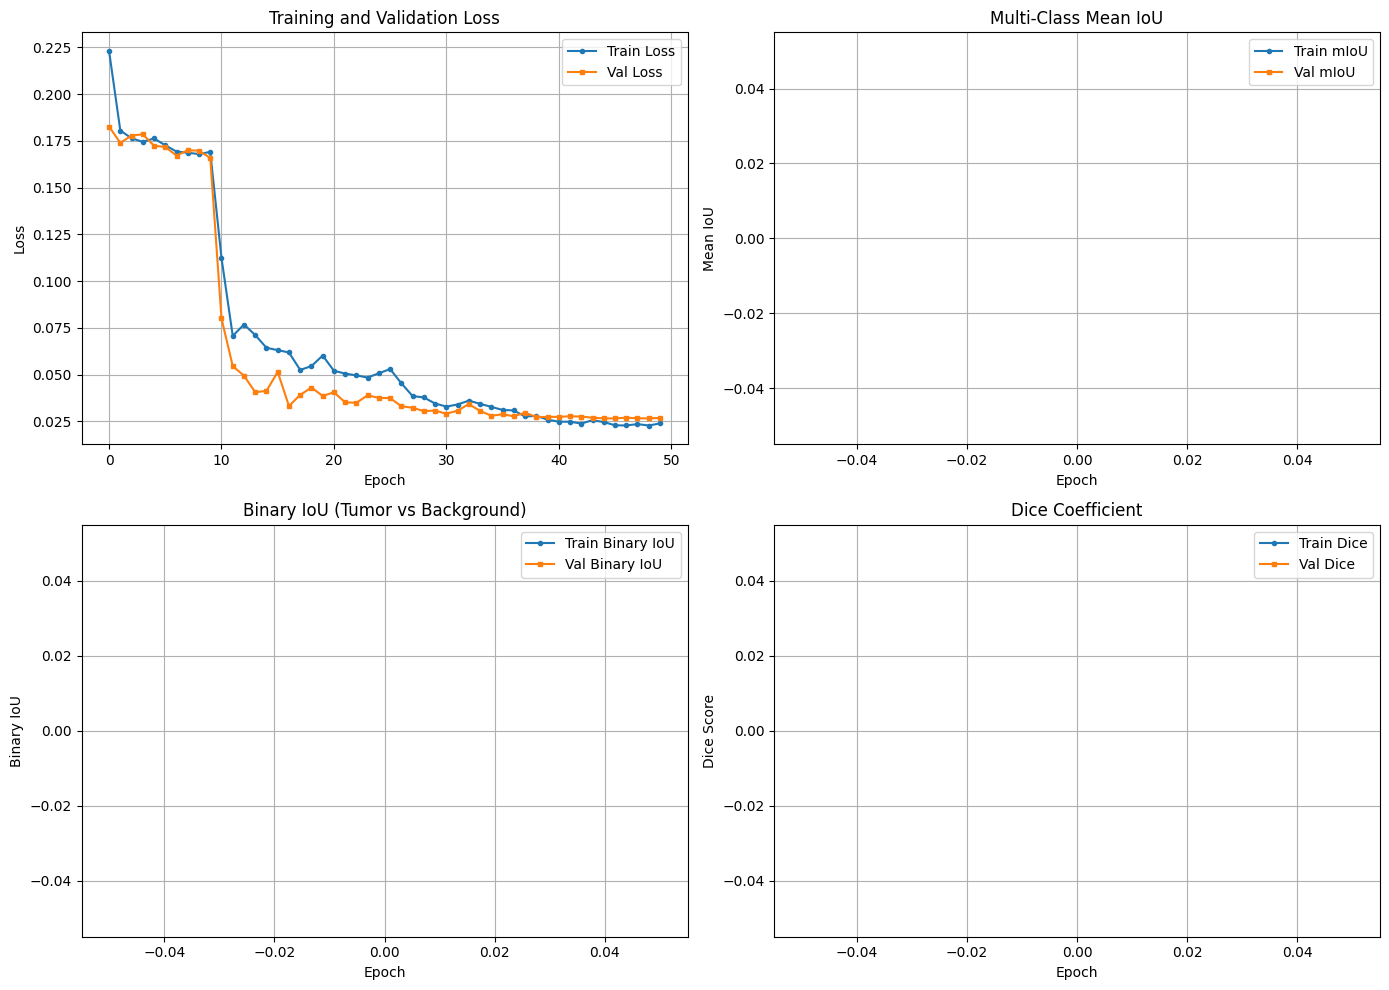

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Multi-class IoU
axes[0, 1].plot(history['train_iou'], label='Train mIoU', marker='o', markersize=3)
axes[0, 1].plot(history['val_iou'], label='Val mIoU', marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Mean IoU')
axes[0, 1].set_title('Multi-Class Mean IoU')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Binary IoU (tumor vs background)
axes[1, 0].plot(history['train_binary_iou'], label='Train Binary IoU', marker='o', markersize=3)
axes[1, 0].plot(history['val_binary_iou'], label='Val Binary IoU', marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Binary IoU')
axes[1, 0].set_title('Binary IoU (Tumor vs Background)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Dice
axes[1, 1].plot(history['train_dice'], label='Train Dice', marker='o', markersize=3)
axes[1, 1].plot(history['val_dice'], label='Val Dice', marker='s', markersize=3)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Dice Score')
axes[1, 1].set_title('Dice Coefficient')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Phase 4: Evaluation and Visualization

### 13. Evaluate and Visualize Predictions on Validation Set

✓ Best model loaded (Binary IoU: 0.7213)
✓ Using standard inference (TTA disabled)


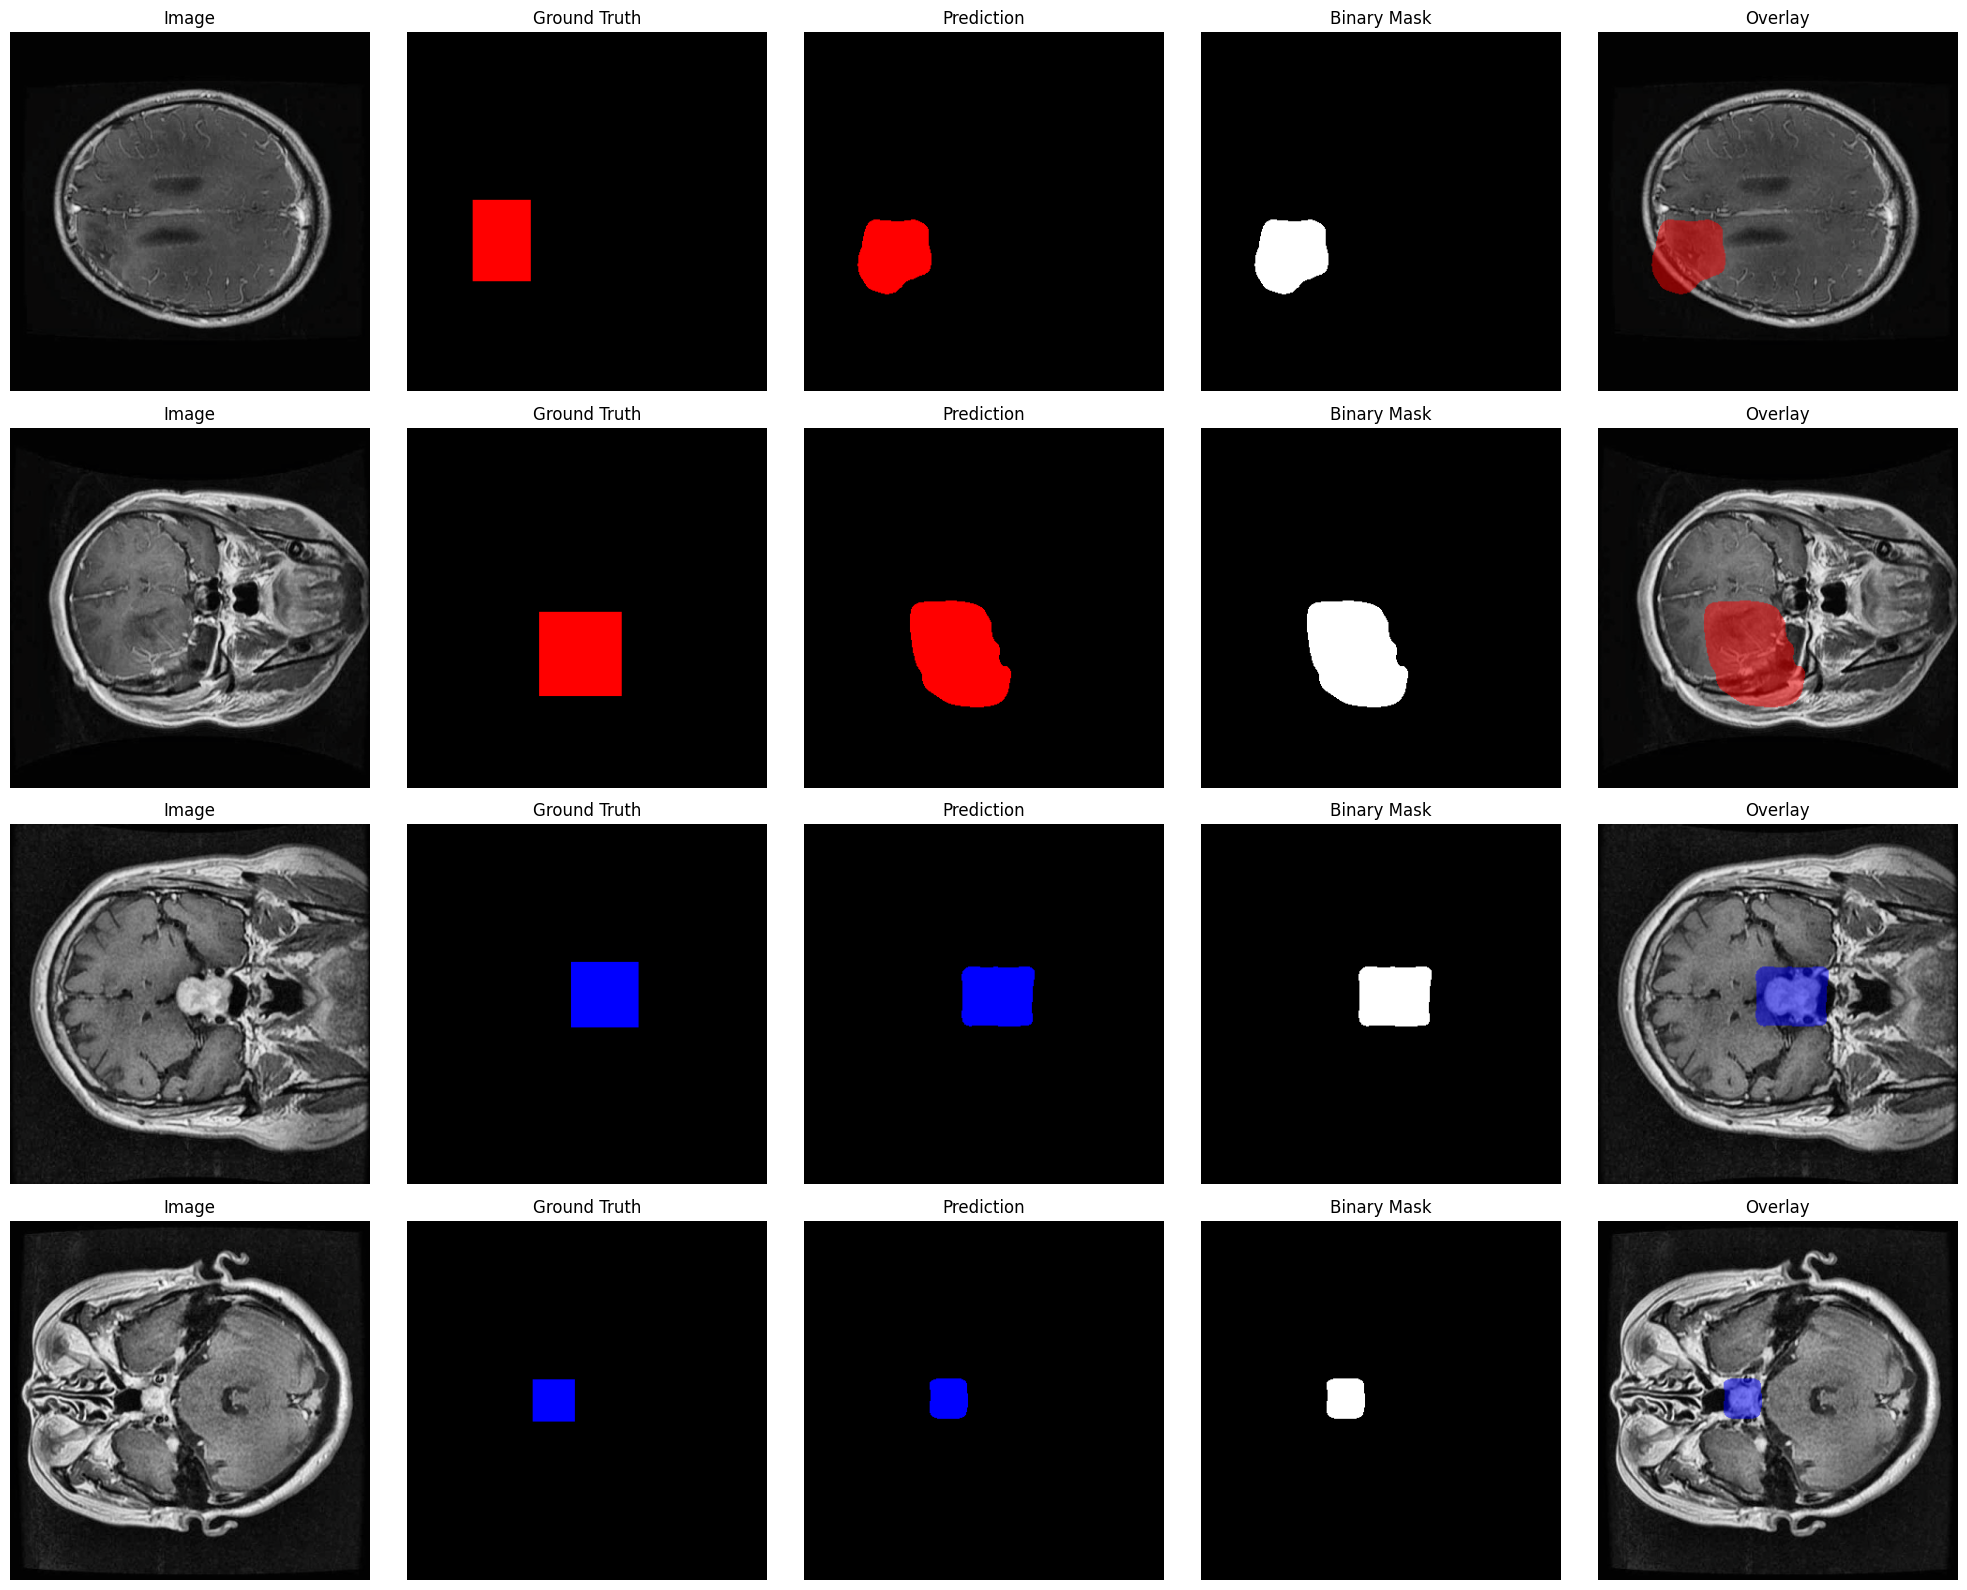


✓ Inference mode: Standard
Legend: 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1


In [16]:
# Load best model
checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

saved_binary_iou = checkpoint.get('binary_iou')
print(f"✓ Best model loaded (Binary IoU: {saved_binary_iou:.4f})" if saved_binary_iou else "✓ Best model loaded")

# Compute validation metrics (with TTA comparison if enabled)
if USE_TTA:
    print("\nComputing validation metrics with TTA...")
    total_binary_iou_tta = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validation TTA"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            avg_probs = predict_with_tta(model, images, DEVICE)
            binary_iou = calculate_binary_iou(avg_probs, masks)
            
            total_binary_iou_tta += binary_iou
            num_batches += 1

    avg_binary_iou_tta = total_binary_iou_tta / num_batches
    improvement = (avg_binary_iou_tta - saved_binary_iou) * 100 if saved_binary_iou else 0

    print(f"\n{'=' * 50}")
    print(f"  Original Binary IoU:  {saved_binary_iou:.4f} ({saved_binary_iou*100:.2f}%)")
    print(f"  TTA Binary IoU:       {avg_binary_iou_tta:.4f} ({avg_binary_iou_tta*100:.2f}%)")
    print(f"  Improvement:          {'+' if improvement >= 0 else ''}{improvement:.2f}%")
    print(f"{'=' * 50}")
else:
    print(f"✓ Using standard inference (TTA disabled)")

# Get validation samples for visualization
val_iter = iter(valid_loader)
images, masks = next(val_iter)
images = images.to(DEVICE)

# Run inference
with torch.no_grad():
    if USE_TTA:
        probs = predict_with_tta(model, images, DEVICE)
        predictions = probs.argmax(dim=1)
    else:
        outputs = model(images)
        predictions = outputs.argmax(dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
predictions = predictions.cpu()

# Denormalize images
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

num_samples = min(4, len(images))
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Denormalize image
    img = images[i] * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    true_mask = masks[i].numpy()
    pred_mask = predictions[i].numpy()
    
    # Create colored versions
    true_color = mask_to_color(true_mask)
    pred_color = mask_to_color(pred_mask)
    
    # Create overlay
    overlay = img.copy()
    for c in [1, 2]:
        mask_c = (pred_mask == c)
        if mask_c.any():
            color = np.array(CLASS_COLORS[c]) / 255.0
            overlay[mask_c] = overlay[mask_c] * 0.5 + color * 0.5
    
    # Plot
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(true_color)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_color)
    axes[i, 2].set_title('Prediction (TTA)' if USE_TTA else 'Prediction')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow((pred_mask > 0).astype(np.uint8), cmap='gray')
    axes[i, 3].set_title('Binary Mask')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(overlay)
    axes[i, 4].set_title('Overlay')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Inference mode: {'TTA (8 augmentations)' if USE_TTA else 'Standard'}")
print("Legend: 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1")

### 14. Inference on Test Set

In [17]:
# Simple test dataset (loads images without annotations)
class SimpleTestDataset(Dataset):
    """Dataset for test inference without ground truth annotations."""
    
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(img_dir) 
            if f.lower().endswith(self.VALID_EXTENSIONS)
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, idx, filename


# Create test dataset and loader
test_dataset = SimpleTestDataset(img_dir=TEST_DIR, transform=get_valid_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"✓ Test dataset: {len(test_dataset)} images")
print(f"✓ Inference mode: {'TTA (8 augmentations)' if USE_TTA else 'Standard'}")

# Run inference
test_predictions = {}
model.eval()

with torch.no_grad():
    for image_tensor, img_id, filename in tqdm(test_loader, desc="Inference"):
        image_tensor = image_tensor.to(DEVICE)
        
        if USE_TTA:
            probs = predict_with_tta(model, image_tensor, DEVICE)
            pred_mask = probs.argmax(dim=1).squeeze().cpu().numpy()
        else:
            outputs = model(image_tensor)
            pred_mask = outputs.argmax(dim=1).squeeze().cpu().numpy()
        
        img_id = img_id.item()
        filename = filename[0]
        test_predictions[img_id] = {
            'filename': filename,
            'mask': pred_mask,
            'binary_mask': (pred_mask > 0).astype(np.uint8)
        }

print(f"\n✓ Inference completed on {len(test_predictions)} images")

✓ Test dataset: 215 images
✓ Inference mode: Standard


Inference: 100%|█████████████████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 21.12it/s]


✓ Inference completed on 215 images


### 15. Post-Processing: Convert Masks to Polygons

In [18]:
def mask_to_coco_annotations(mask, image_id, start_annotation_id, min_area=None):
    """
    Convert multi-class mask to COCO format annotations.
    
    Args:
        mask: Multi-class mask (0=background, 1=tumor type 0, 2=tumor type 1)
        image_id: COCO image ID
        start_annotation_id: Starting annotation ID
        min_area: Minimum contour area (uses MIN_CONTOUR_AREA config if None)
    
    Returns:
        annotations: List of COCO annotation dictionaries
        next_annotation_id: Next available annotation ID
    """
    if min_area is None:
        min_area = MIN_CONTOUR_AREA
    
    annotations = []
    annotation_id = start_annotation_id
    
    # Process each tumor class
    for class_id in [1, 2]:
        class_mask = (mask == class_id).astype(np.uint8) * 255
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_area:
                continue
            
            x, y, w, h = cv2.boundingRect(contour)
            
            annotations.append({
                "id": int(annotation_id),
                "image_id": int(image_id),
                "category_id": int(class_id),
                "bbox": [float(x), float(y), float(w), float(h)],
                "area": float(area),
                "segmentation": [contour.flatten().tolist()],
                "iscrowd": 0
            })
            annotation_id += 1
    
    return annotations, annotation_id


# Test the function
sample_id = list(test_predictions.keys())[0]
sample_mask = test_predictions[sample_id]['mask']
sample_anns, _ = mask_to_coco_annotations(sample_mask, sample_id, 0)

print(f"✓ Polygon conversion function defined")
print(f"  Minimum contour area: {MIN_CONTOUR_AREA} pixels")
print(f"  Sample: {len(sample_anns)} contours in first image")
if sample_anns:
    categories = set(ann['category_id'] for ann in sample_anns)
    print(f"  Categories found: {categories}")

✓ Polygon conversion function defined
  Minimum contour area: 50 pixels
  Sample: 1 contours in first image
  Categories found: {2}


### 16. Resize Masks to Original Resolution

In [19]:
# Resize predicted masks to original resolution
resized_predictions = {}

for img_id, pred_data in tqdm(test_predictions.items(), desc="Resizing masks"):
    filename = pred_data['filename']
    mask = pred_data['mask']
    
    # Get original image dimensions
    original_img = cv2.imread(os.path.join(TEST_DIR, filename))
    original_height, original_width = original_img.shape[:2]
    
    # Resize mask using nearest neighbor to preserve class values
    resized_mask = cv2.resize(
        mask.astype(np.uint8), 
        (original_width, original_height), 
        interpolation=cv2.INTER_NEAREST
    )
    
    resized_predictions[img_id] = {
        'filename': filename,
        'mask': resized_mask,
        'binary_mask': (resized_mask > 0).astype(np.uint8),
        'height': original_height,
        'width': original_width
    }

print(f"✓ Resized {len(resized_predictions)} masks to original resolution")

Resizing masks: 100%|██████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 1093.65it/s]

✓ Resized 215 masks to original resolution


### 17. Generate COCO JSON for Test Predictions

Build the complete COCO JSON structure with all required fields.

In [20]:
# Load template structure from training annotations
with open(TRAIN_ANNOTATIONS, 'r') as f:
    coco_template = json.load(f)

# Initialize COCO output
coco_output = {
    "info": coco_template["info"],
    "licenses": coco_template["licenses"],
    "categories": coco_template["categories"],
    "images": [],
    "annotations": []
}

# Generate annotations
annotation_id = 0
category_counts = {1: 0, 2: 0}

for img_id, pred_data in tqdm(resized_predictions.items(), desc="Generating COCO JSON"):
    # Add image info
    coco_output["images"].append({
        "id": int(img_id),
        "license": 1,
        "file_name": pred_data['filename'],
        "height": int(pred_data['height']),
        "width": int(pred_data['width']),
        "date_captured": "2023-08-19T04:37:54+00:00"
    })
    
    # Convert mask to annotations
    annotations, annotation_id = mask_to_coco_annotations(
        pred_data['mask'], img_id, annotation_id
    )
    
    for ann in annotations:
        category_counts[ann['category_id']] += 1
    
    coco_output["annotations"].extend(annotations)

print(f"\n{'=' * 50}")
print("COCO JSON Summary:")
print(f"  Images:      {len(coco_output['images'])}")
print(f"  Annotations: {len(coco_output['annotations'])}")
print(f"  Category 1 (Tumor type 0): {category_counts[1]}")
print(f"  Category 2 (Tumor type 1): {category_counts[2]}")
print(f"{'=' * 50}")

Generating COCO JSON: 100%|████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 4389.65it/s]


COCO JSON Summary:
  Images:      215
  Annotations: 224
  Category 1 (Tumor type 0): 126
  Category 2 (Tumor type 1): 98


### 18. Save Results

Save the generated COCO JSON and predicted masks to a results folder.

In [21]:
# Create output directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MASK_OUTPUT_DIR, exist_ok=True)
os.makedirs(OVERLAY_OUTPUT_DIR, exist_ok=True)

# Save COCO JSON
with open(OUTPUT_JSON_PATH, 'w') as f:
    json.dump(coco_output, f, indent=2)

print(f"✓ Annotations saved: {OUTPUT_JSON_PATH}")
print(f"  File size: {os.path.getsize(OUTPUT_JSON_PATH) / 1024:.2f} KB")

# Save masks and overlays
masks_saved = 0
overlays_saved = 0

for img_id, pred_data in tqdm(resized_predictions.items(), desc="Saving results"):
    filename = pred_data['filename']
    mask = pred_data['mask']
    binary_mask = pred_data['binary_mask']
    base_name = os.path.splitext(filename)[0]
    
    # Save binary mask
    mask_path = os.path.join(MASK_OUTPUT_DIR, f"{base_name}_mask.png")
    cv2.imwrite(mask_path, (binary_mask * 255).astype(np.uint8))
    masks_saved += 1
    
    # Create and save overlay
    original_img = cv2.imread(os.path.join(TEST_DIR, filename))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    overlay = original_img.copy().astype(np.float32)
    for class_id in [1, 2]:
        class_mask = (mask == class_id)
        if class_mask.any():
            color = np.array(CLASS_COLORS[class_id], dtype=np.float32)
            overlay[class_mask] = overlay[class_mask] * 0.4 + color * 0.6
    
    overlay = overlay.astype(np.uint8)
    
    # Add contour outlines
    for class_id in [1, 2]:
        class_mask_uint8 = ((mask == class_id).astype(np.uint8) * 255)
        contours, _ = cv2.findContours(class_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, CLASS_COLORS[class_id], 2)
    
    overlay_path = os.path.join(OVERLAY_OUTPUT_DIR, f"{base_name}_overlay.png")
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    overlays_saved += 1

# Verify JSON
with open(OUTPUT_JSON_PATH, 'r') as f:
    verification = json.load(f)

print(f"\n{'=' * 50}")
print("Results Summary:")
print(f"  Images:      {len(verification['images'])}")
print(f"  Annotations: {len(verification['annotations'])}")
print(f"  Masks:       {masks_saved} files")
print(f"  Overlays:    {overlays_saved} files")
print(f"\nOutput Structure:")
print(f"  {RESULTS_DIR}/")
print(f"    ├── _annotations.coco.json")
print(f"    ├── masks/")
print(f"    └── overlays/")
print(f"{'=' * 50}")

✓ Annotations saved: results/_annotations.coco.json
  File size: 863.21 KB


Saving results: 100%|███████████████████████████████████████████████████████████████████████████| 215/215 [00:02<00:00, 101.10it/s]


Results Summary:
  Images:      215
  Annotations: 224
  Masks:       215 files
  Overlays:    215 files

Output Structure:
  results/
    ├── _annotations.coco.json
    ├── masks/
    └── overlays/


### 19. Visualize Sample Test Predictions

Let's visualize some predictions on the test set.

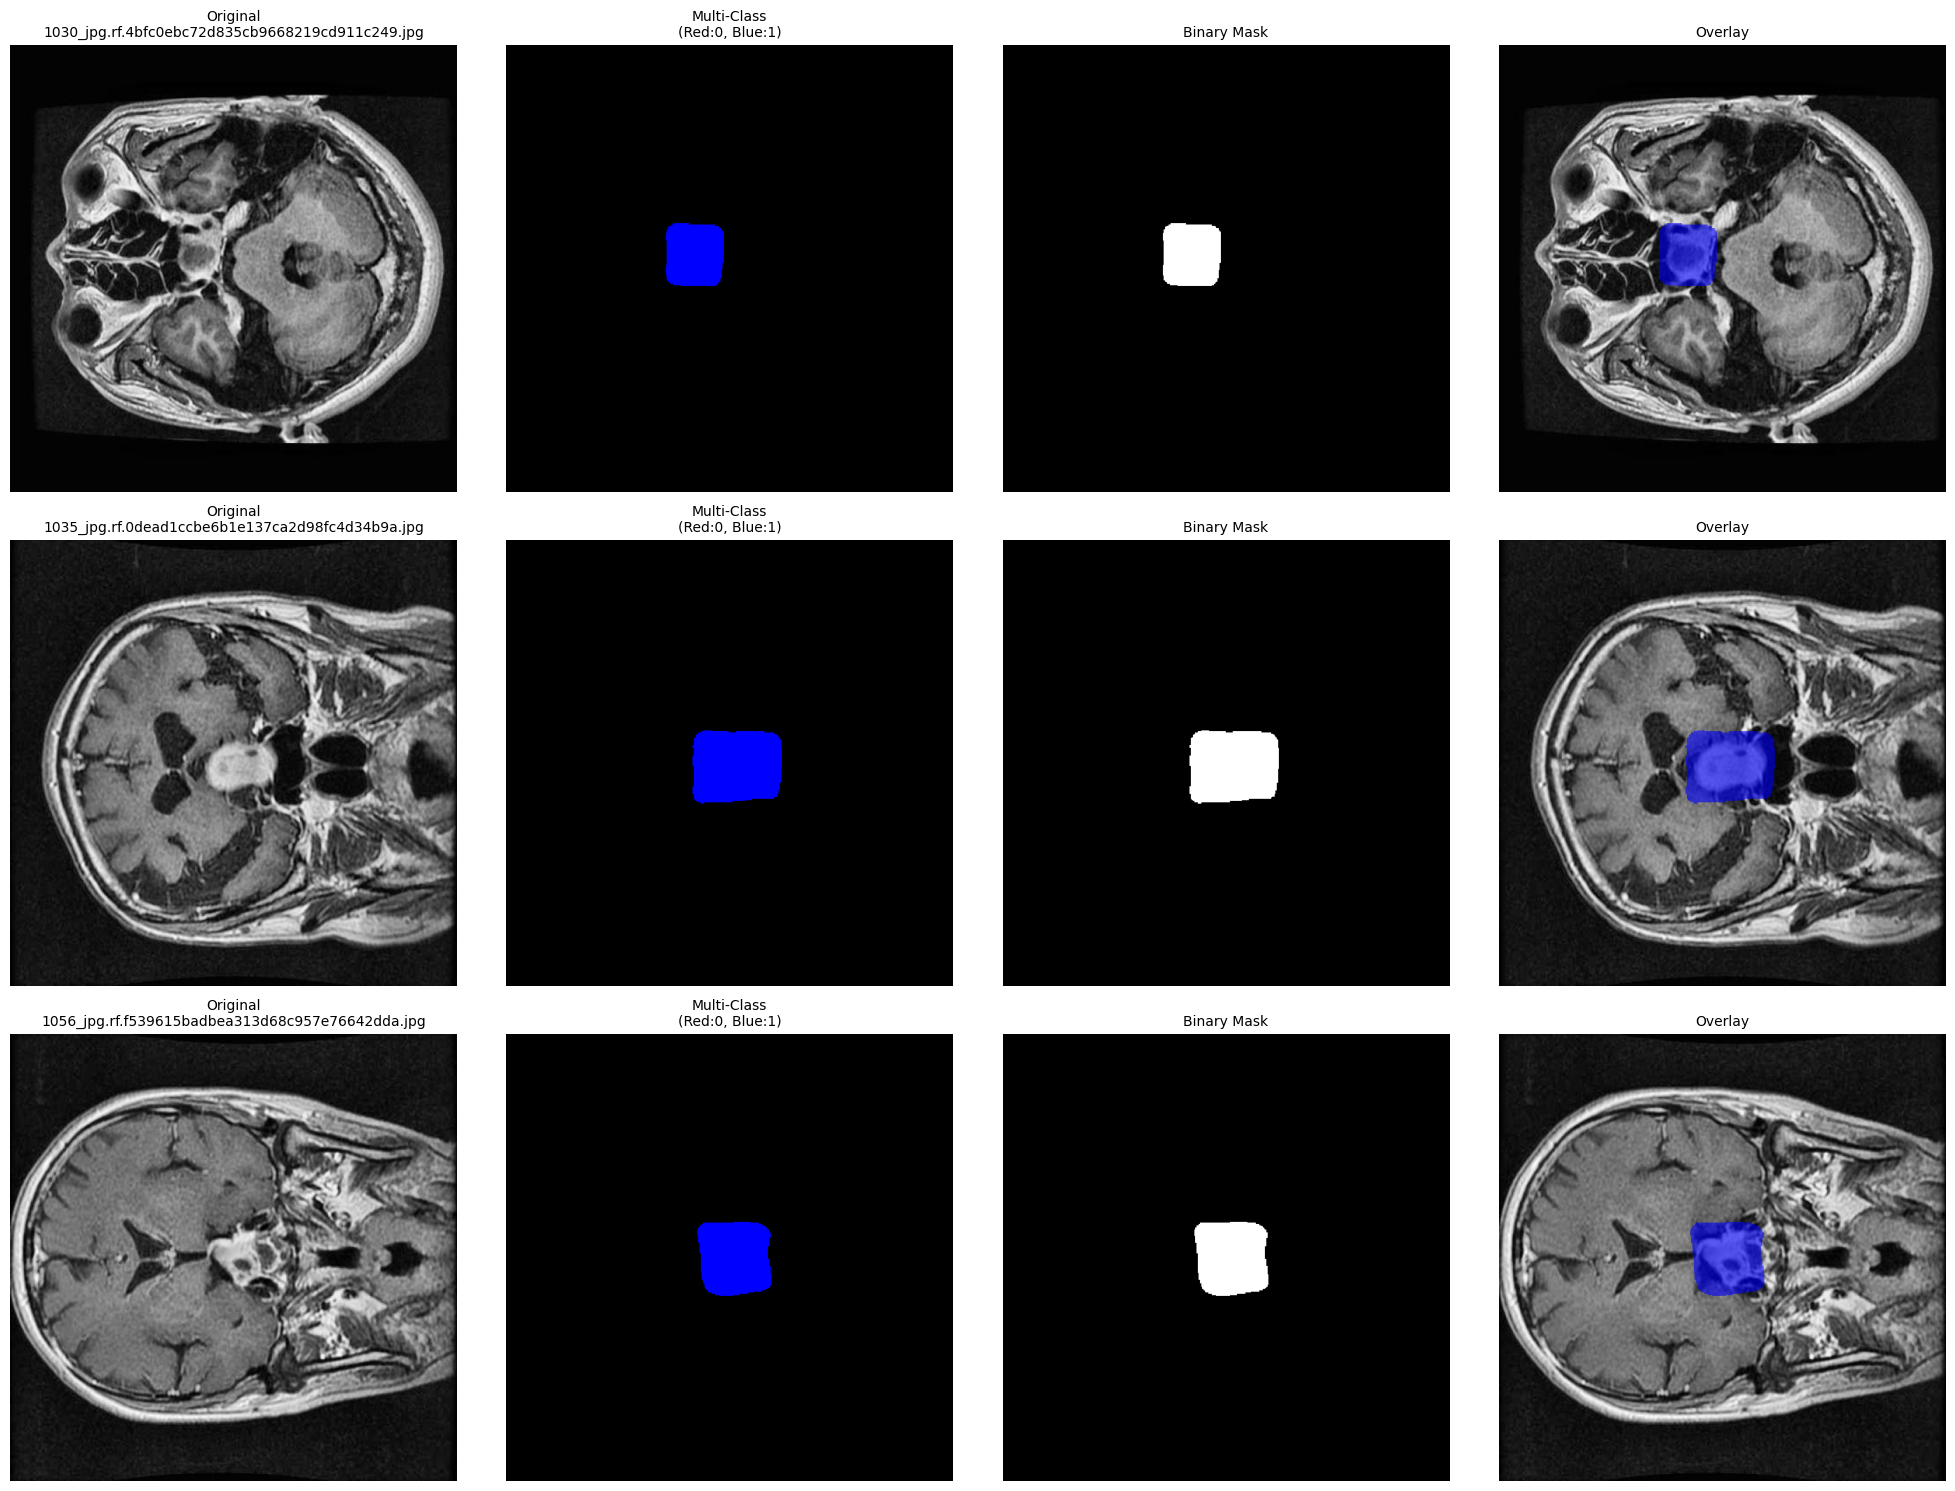

✓ Visualized 3 test predictions
  Legend: 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1


In [22]:
# Visualize test predictions
num_samples = min(3, len(resized_predictions))

if num_samples == 0:
    print("No predictions to visualize!")
else:
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_ids = list(resized_predictions.keys())[:num_samples]
    
    for i, img_id in enumerate(sample_ids):
        pred_data = resized_predictions[img_id]
        filename = pred_data['filename']
        mask = pred_data['mask']
        binary_mask = pred_data['binary_mask']
        
        # Load original image
        image = cv2.imread(os.path.join(TEST_DIR, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Create colored mask and overlay
        color_mask = mask_to_color(mask)
        overlay = image.copy().astype(np.float32)
        for class_id in [1, 2]:
            class_mask = (mask == class_id)
            if class_mask.any():
                color = np.array(CLASS_COLORS[class_id], dtype=np.float32)
                overlay[class_mask] = overlay[class_mask] * 0.4 + color * 0.6
        
        # Count regions per class
        c1_count = len(cv2.findContours(((mask == 1).astype(np.uint8) * 255), 
                                         cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])
        c2_count = len(cv2.findContours(((mask == 2).astype(np.uint8) * 255), 
                                         cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])
        
        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original\n{filename}", fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(color_mask)
        axes[i, 1].set_title(f"Multi-Class\n(Red:{c1_count}, Blue:{c2_count})", fontsize=10)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(binary_mask, cmap='gray')
        axes[i, 2].set_title("Binary Mask", fontsize=10)
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(overlay.astype(np.uint8))
        axes[i, 3].set_title("Overlay", fontsize=10)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualized {num_samples} test predictions")
    print("  Legend: 🔴 Red = Tumor Type 0, 🔵 Blue = Tumor Type 1")

## Phase 5: Conclusion

### 20. Data Exploration Summary

Summarize the dataset statistics and exploration findings.

In [23]:
# Load COCO data for statistics
with open(TRAIN_ANNOTATIONS, 'r') as f:
    train_coco = json.load(f)
with open(VALID_ANNOTATIONS, 'r') as f:
    valid_coco = json.load(f)

print(f"\nDataset Overview:")
print(f"   Training Images:   {len(train_coco['images'])}")
print(f"   Validation Images: {len(valid_coco['images'])}")
print(f"   Test Images:       {len(test_dataset)}")
print(f"   Total Images:      {len(train_coco['images']) + len(valid_coco['images']) + len(test_dataset)}")

print(f"\nTarget Categories: {TUMOR_CATEGORY_IDS} (Combined as binary tumor class)")

# Analyze training set distribution
train_images_with_tumors = len(set([ann['image_id'] for ann in train_coco['annotations'] 
                                     if ann['category_id'] in TUMOR_CATEGORY_IDS]))
valid_images_with_tumors = len(set([ann['image_id'] for ann in valid_coco['annotations'] 
                                     if ann['category_id'] in TUMOR_CATEGORY_IDS]))

print(f"\nTumor Distribution:")
print(f"   Training Set - Images with Tumors:   {train_images_with_tumors}/{len(train_coco['images'])} ({train_images_with_tumors/len(train_coco['images'])*100:.1f}%)")
print(f"   Validation Set - Images with Tumors: {valid_images_with_tumors}/{len(valid_coco['images'])} ({valid_images_with_tumors/len(valid_coco['images'])*100:.1f}%)")


Dataset Overview:
   Training Images:   1502
   Validation Images: 429
   Test Images:       215
   Total Images:      2146

Target Categories: [1, 2] (Combined as binary tumor class)

Tumor Distribution:
   Training Set - Images with Tumors:   1501/1502 (99.9%)
   Validation Set - Images with Tumors: 429/429 (100.0%)


### 21. Validation Set Performance - Pixel Accuracy and IoU

Evaluate the model's performance on the validation set, reporting pixel accuracy and IoU metrics.

In [24]:
# Validation Set Performance Evaluation
print("VALIDATION SET PERFORMANCE")
print("=" * 50)

model.eval()

# Initialize accumulators
total_correct_pixels = 0
total_pixels = 0
total_iou = 0.0
total_dice = 0.0
total_binary_iou = 0.0
num_batches = 0
class_ious = {1: [], 2: []}

# TTA accumulators (only used if TTA enabled)
if USE_TTA:
    total_binary_iou_tta = 0.0
    class_ious_tta = {1: [], 2: []}

with torch.no_grad():
    for images, masks in tqdm(valid_loader, desc="Computing metrics"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Standard inference
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        # Pixel accuracy
        correct = (preds == masks).float()
        total_correct_pixels += correct.sum().item()
        total_pixels += masks.numel()
        
        # Multi-class metrics
        iou, per_class = calculate_iou_multiclass(outputs, masks, NUM_CLASSES)
        dice = calculate_dice_multiclass(outputs, masks, NUM_CLASSES)
        binary_iou = calculate_binary_iou(outputs, masks)
        
        total_iou += iou
        total_dice += dice
        total_binary_iou += binary_iou
        num_batches += 1
        
        for c in [1, 2]:
            if per_class[c] is not None:
                class_ious[c].append(per_class[c])
        
        # TTA metrics
        if USE_TTA:
            tta_probs = predict_with_tta(model, images, DEVICE)
            _, per_class_tta = calculate_iou_multiclass(tta_probs, masks, NUM_CLASSES)
            binary_iou_tta = calculate_binary_iou(tta_probs, masks)
            total_binary_iou_tta += binary_iou_tta
            
            for c in [1, 2]:
                if per_class_tta[c] is not None:
                    class_ious_tta[c].append(per_class_tta[c])

# Calculate averages
pixel_accuracy = total_correct_pixels / total_pixels
avg_iou = total_iou / num_batches
avg_dice = total_dice / num_batches
avg_binary_iou = total_binary_iou / num_batches

print(f"\n{'=' * 50}")
print("Standard Inference:")
print(f"  Multi-Class Mean IoU: {avg_iou:.4f} ({avg_iou*100:.2f}%)")
print(f"  Binary IoU (Tumor):   {avg_binary_iou:.4f} ({avg_binary_iou*100:.2f}%)")
print(f"  Dice Score:           {avg_dice:.4f} ({avg_dice*100:.2f}%)")
print(f"  Pixel Accuracy:       {pixel_accuracy:.4f} ({pixel_accuracy*100:.2f}%)")

print(f"\nPer-Class IoU:")
for c in [1, 2]:
    if class_ious[c]:
        mean_iou = np.mean(class_ious[c])
        print(f"  Class {c} (Tumor type {c-1}): {mean_iou:.4f} ({mean_iou*100:.2f}%)")

if USE_TTA:
    avg_binary_iou_tta = total_binary_iou_tta / num_batches
    improvement = (avg_binary_iou_tta - avg_binary_iou) * 100
    
    print(f"\n{'=' * 50}")
    print("TTA Inference (8 augmentations):")
    print(f"  Binary IoU (TTA):   {avg_binary_iou_tta:.4f} ({avg_binary_iou_tta*100:.2f}%)")
    print(f"  Improvement:        {'+' if improvement >= 0 else ''}{improvement:.2f}%")
    
    print(f"\nPer-Class IoU (TTA):")
    for c in [1, 2]:
        if class_ious_tta[c]:
            mean_iou = np.mean(class_ious_tta[c])
            print(f"  Class {c} (Tumor type {c-1}): {mean_iou:.4f} ({mean_iou*100:.2f}%)")

print(f"\n{'=' * 50}")
print("SUMMARY:")
print(f"  Binary IoU: {avg_binary_iou*100:.2f}%")
if USE_TTA:
    print(f"  Binary IoU (TTA): {avg_binary_iou_tta*100:.2f}%")
print(f"{'=' * 50}")

VALIDATION SET PERFORMANCE


Computing metrics: 100%|█████████████████████████████████████████████████████████████████████████| 108/108 [00:21<00:00,  5.10it/s]


Standard Inference:
  Multi-Class Mean IoU: 0.7194 (71.94%)
  Binary IoU (Tumor):   0.7213 (72.13%)
  Dice Score:           0.8263 (82.63%)
  Pixel Accuracy:       0.9863 (98.63%)

Per-Class IoU:
  Class 1 (Tumor type 0): 0.6576 (65.76%)
  Class 2 (Tumor type 1): 0.7799 (77.99%)

SUMMARY:
  Binary IoU: 72.13%


### 22. Test Results and Output Location

Summary of test predictions and location of generated output files.

In [25]:
# Final Summary
print("=" * 50)
print("TEST PREDICTION SUMMARY")
print("=" * 50)

# Count statistics
cat1_count = sum(1 for ann in coco_output['annotations'] if ann['category_id'] == 1)
cat2_count = sum(1 for ann in coco_output['annotations'] if ann['category_id'] == 2)
images_with_tumors = sum(1 for pred in resized_predictions.values() if pred['binary_mask'].any())
images_without_tumors = len(resized_predictions) - images_with_tumors

print(f"\nInference Results:")
print(f"  Total images:           {len(test_predictions)}")
print(f"  Images with tumor:      {images_with_tumors} ({images_with_tumors/len(test_predictions)*100:.1f}%)")
print(f"  Images without tumor:   {images_without_tumors} ({images_without_tumors/len(test_predictions)*100:.1f}%)")

print(f"\nAnnotation Breakdown:")
print(f"  Total annotations:      {len(coco_output['annotations'])}")
print(f"  Category 1 (Type 0):    {cat1_count}")
print(f"  Category 2 (Type 1):    {cat2_count}")

print(f"\nOutput Files:")
print(f"  Model:       {BEST_MODEL_PATH}")
print(f"  Annotations: {OUTPUT_JSON_PATH}")
print(f"  Masks:       {MASK_OUTPUT_DIR}/ ({masks_saved} files)")
print(f"  Overlays:    {OVERLAY_OUTPUT_DIR}/ ({overlays_saved} files)")

print(f"\n{'=' * 50}")
print("Formats:")
print("  • Masks:    Binary (black=background, white=tumor)")
print("  • Overlays: Colored (Red=Type0, Blue=Type1)")
print("  • JSON:     COCO format with category_id per region")
print(f"{'=' * 50}")

TEST PREDICTION SUMMARY

Inference Results:
  Total images:           215
  Images with tumor:      215 (100.0%)
  Images without tumor:   0 (0.0%)

Annotation Breakdown:
  Total annotations:      224
  Category 1 (Type 0):    126
  Category 2 (Type 1):    98

Output Files:
  Model:       models/best_model.pth
  Annotations: results/_annotations.coco.json
  Masks:       results/masks/ (215 files)
  Overlays:    results/overlays/ (215 files)

Formats:
  • Masks:    Binary (black=background, white=tumor)
  • Overlays: Colored (Red=Type0, Blue=Type1)
  • JSON:     COCO format with category_id per region
